In [9]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import dnn_utils
import lr_utils
import testCases
np.random.seed(1)

In [10]:
def init_params(n_x, n_h, n_y):
    '''
    params:
    n_x:输入层节点数
    n_h:隐含层节点数
    n_y:输出层节点数
    
    return:
    W1:维度(n_h,n_x)
    b1:维度(n_h,1)
    W2:维度(n_y,n_h)
    b2:维度(n_y,1)
    '''
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape = (n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape = (n_y, 1))
    
    assert W1.shape == (n_h, n_x)
    assert b1.shape == (n_h, 1)
    assert W2.shape == (n_y, n_h)
    assert b2.shape == (n_y, 1)
    
    params = {
        'W1' : W1,
        'b1' : b1,
        'W2' : W2,
        'b2' : b2
    }
    
    return params

In [11]:
#测试init_params
params = init_params(3, 2, 1)
print('W1:' + str(params['W1']))
print('b1:' + str(params['b1']))
print('W2:' + str(params['W2']))
print('b2:' + str(params['b2']))

W1:[[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1:[[0.]
 [0.]]
W2:[[ 0.01744812 -0.00761207]]
b2:[[0.]]


In [12]:
def init_deep_params(layer_units):
    """
    param:
    layer_units:每个隐含层的节点数量的数组
    
    return:
    包含W1,b1,W2,b2,...,Wl,bl的字典
    """
    np.random.seed(1)
    params = {}
    L = len(layer_units)
    
    for i in range(1, L):
        params['W' + str(i)] = np.random.randn(layer_units[i], layer_units[i - 1]) / np.sqrt(layer_units[i - 1])
        params['b' + str(i)] = np.zeros(shape = (layer_units[i], 1))
        
        assert params['W' + str(i)].shape == (layer_units[i], layer_units[i - 1])
        assert params['b' + str(i)].shape == (layer_units[i], 1)
    
    return params

In [15]:
#测试init_deep_params
layer_units = [5, 4, 3]
params = init_deep_params(layer_units)
print('W1:' + str(params['W1']))
print('b1:' + str(params['b1']))
print('W2:' + str(params['W2']))
print('b2:' + str(params['b2']))

W1:[[ 0.72642933 -0.27358579 -0.23620559 -0.47984616  0.38702206]
 [-1.0292794   0.78030354 -0.34042208  0.14267862 -0.11152182]
 [ 0.65387455 -0.92132293 -0.14418936 -0.17175433  0.50703711]
 [-0.49188633 -0.07711224 -0.39259022  0.01887856  0.26064289]]
b1:[[0.]
 [0.]
 [0.]
 [0.]]
W2:[[-0.55030959  0.57236185  0.45079536  0.25124717]
 [ 0.45042797 -0.34186393 -0.06144511 -0.46788472]
 [-0.13394404  0.26517773 -0.34583038 -0.19837676]]
b2:[[0.]
 [0.]
 [0.]]


In [17]:
#前向传播分为线性部分z = wx + b 和 激活部分A = Activate(z)
def linear_forward(A, W, b):
    '''
    param:
    A:来自上一层的激活值
    W:权重矩阵 维度(L,L-1)L表示本层节点数量
    b:偏移量矩阵 维度(L,1)
    
    return:
    Z:Z = WA + b 用于给激活函数作为输入
    cache:包含A,W,b的字典用来计算后向传播
    '''
    Z = np.dot(W,A) + b
    assert Z.shape == (W.shape[0],A.shape[1])
    cache = (A,W,b)
    
    return Z,cache

In [19]:
#测试linear_forward
A, W, b = testCases.linear_forward_test_case()
Z, cache = linear_forward(A, W, b)
print('Z =', Z)

Z = [[ 3.26295337 -1.23429987]]


In [20]:
#定义前向传播的激活部分
def linear_forward_activation(A_ahead, W, b, activate):
    """
    param:
    A_ahead:前一层的激活值 维度(l-1,m)l-1上一层的节点数,m样本数
    W:权重矩阵 维度(l,l-1)l本层的节点数
    b:偏移矩阵 维度(l.1)
    activate:激活函数可选['sigmoid' or 'relu']
    
    return:
    A:激活函数的输出值
    cache:包含线性缓存linear_cache和激活缓存activate_cache的字典 用来计算后向传播
    """
    if activate == 'sigmoid':
        Z, linear_cache = linear_forward(A_ahead, W, b)
        A, activate_cache = dnn_utils.sigmoid(Z)
    elif activate == 'relu':
        Z, linear_cache = linear_forward(A_ahead, W, b)
        A, activate_cache = dnn_utils.relu(Z)
        
    assert A.shape == (W.shape[0], A_ahead.shape[1])
    
    cache = (linear_cache, activate_cache)
    
    return A,cache

In [22]:
#测试linear_forward_activation
A_ahead, W, b = testCases.linear_activation_forward_test_case()
A,cache = linear_forward_activation(A_ahead, W, b, 'sigmoid')
print('sigmoid output:', A)
A,cache = linear_forward_activation(A_ahead, W, b, 'relu')
print('relu output:', A)


sigmoid output: [[0.96890023 0.11013289]]
relu output: [[3.43896131 0.        ]]


为了实现一个有L个隐含层即L-1个relu隐含层和1个sigmoid输出层的多层神经网络，如下图所示
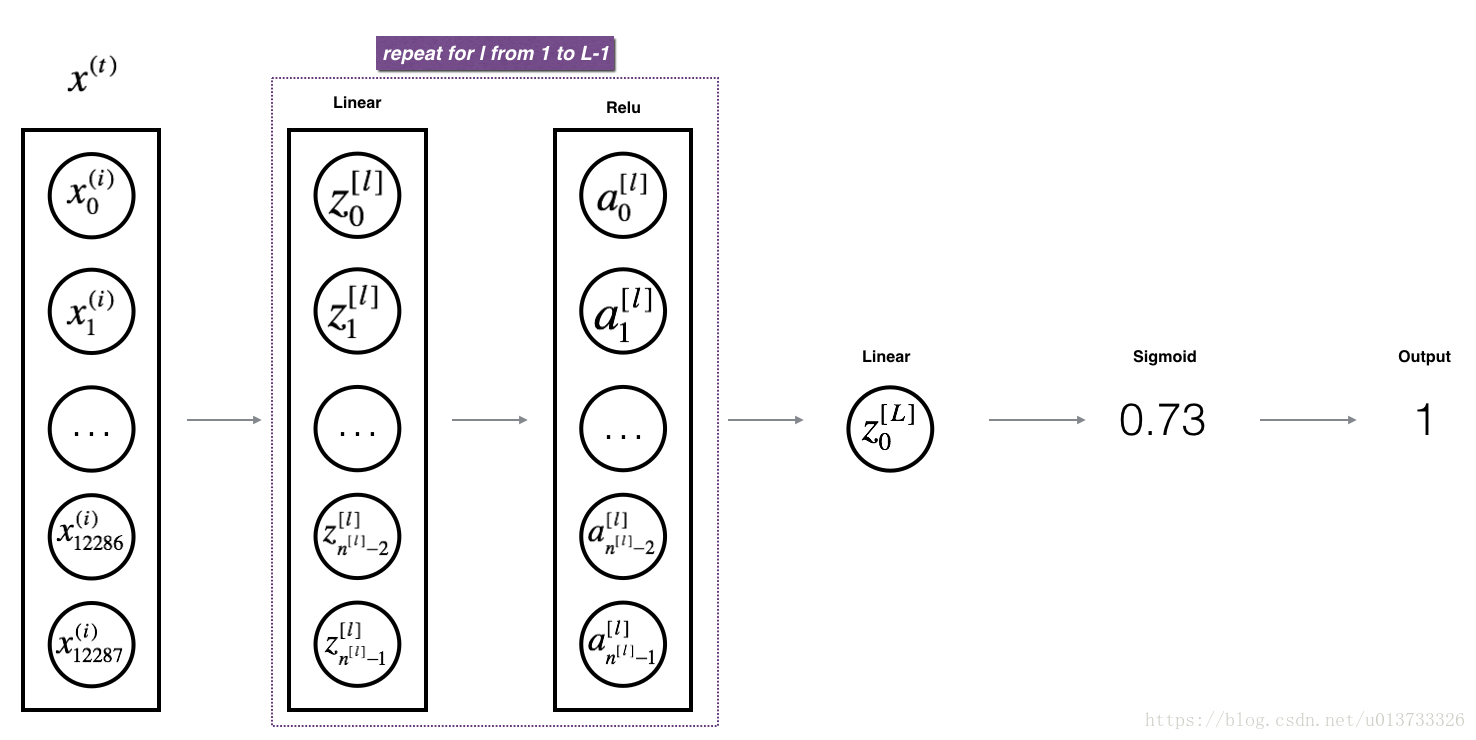

In [26]:
def multi_forward(X,params):
    """
    param:
    X:输入层 (input_units,m) m为样本数
    params:init_deep_params的输出
    
    return:
    A_L:最后一次的激活值
    caches:linear_forward_activation的缓存 共计:L-1个relu的缓存和1个sigmoid的缓存
    """
    caches = []
    A = X
    L = len(params) // 2 #因为params中是W和b的字典，所以层数为对其整除2 
    
    for i in range(1, L):
        A_ahead = A
        A, cache = linear_forward_activation(A_ahead, params['W' + str(i)], params['b' + str(i)], 'relu')
        caches.append(cache)
    A_L, cache = linear_forward_activation(A, params['W' + str(L)], params['b' + str(L)], 'sigmoid')
    caches.append(cache)
    
    assert A_L.shape == (1, X.shape[1])
    
    return A_L,caches

In [27]:
#测试multi_forward
X, params = testCases.L_model_forward_test_case()
A_L, cache = multi_forward(X, params)
print('The final activation =', A_L)

The final activation = [[0.17007265 0.2524272 ]]


In [30]:
#计算成本J
def compute_cost(A_L, Y):
    '''
    param:
    A_L:最后一层的激活函数输出值
    Y:真实标签 维度(1,m) m为样本数量 每个样本的标签为(0|1)
    
    return:
    cost:交叉熵公式
    '''
    
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(A_L), Y) + np.multiply(np.log(1 - A_L), 1 - Y)) / m
    
    cost = np.squeeze(cost)
    assert cost.shape == ()
    
    return cost

In [31]:
#测试compute_cost
Y, A_L = testCases.compute_cost_test_case()
cost = compute_cost(A_L, Y)
print("cost =", cost)

cost = 0.414931599615397


In [38]:
def linear_backward(dZ, cache):
    '''
    param:
    dZ:当前层的成本梯度
    cache:当前层前向传播的缓存 包括(A_ahead, W, b)
    
    return:
    dA_ahead:前面一层的成本梯度
    dW:当前层的W梯度
    db:当前层的b梯度
    '''
    A_ahead, W, b = cache
    m = A_ahead.shape[1]
    dW = np.dot(dZ, A_ahead.T) / m
    db = np.sum(dZ, axis = 1, keepdims = True) / m
    dA_ahead = np.dot(W.T, dZ)
    
    assert dA_ahead.shape == A_ahead.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape
    
    return dA_ahead, dW, db

In [39]:
#测试linear_backward
dZ, cache = testCases.linear_backward_test_case()
dA_ahead, dW, db = linear_backward(dZ, cache)
print('dA_ahead:' + str(dA_ahead))
print('dW:' + str(dW))
print('db:' + str(db))

dA_ahead:[[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW:[[-0.10076895  1.40685096  1.64992505]]
db:[[0.50629448]]


In [40]:
#后向传播
def linear_backward_activate(dA, cache, activate = 'relu'):
    '''
    param:
    dA:当前层激活后的梯度
    cache:用于计算后向传播的缓存 (linear_cache, activate_cache)其中前者(A, W, b)后者是激活函数的输入值
    activate:可选[sigmoid|relu]
    
    return:
    dA_ahead:前面一层的成本梯度
    dW:当前层的W梯度
    db:当前层的b梯度
    '''
    linear_cache, activate_cache = cache
    if activate == 'relu':
        dZ = dnn_utils.relu_backward(dA, activate_cache)
        dA_ahead, dW, db = linear_backward(dZ, linear_cache)
    elif activate == 'sigmoid':
        dZ = dnn_utils.sigmoid_backward(dA, activate_cache)
        dA_ahead, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_ahead, dW, db

In [41]:
#测试linear_backward_activate
dA, cache = testCases.linear_activation_backward_test_case()
dA_ahead, dW, db = linear_backward_activate(dA, cache, activate = 'sigmoid')
print('sigmoid dA_ahead:' + str(dA_ahead))
print('sigmoid dW:' + str(dW))
print('sigmoid db:' + str(db) + '\n')
dA_ahead, dW, db = linear_backward_activate(dA, cache, activate = 'relu')
print('relu dA_ahead:' + str(dA_ahead))
print('relu dW:' + str(dW))
print('relu db:' + str(db) + '\n')

sigmoid dA_ahead:[[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
sigmoid dW:[[ 0.10266786  0.09778551 -0.01968084]]
sigmoid db:[[-0.05729622]]

relu dA_ahead:[[ 0.44090989 -0.        ]
 [ 0.37883606 -0.        ]
 [-0.2298228   0.        ]]
relu dW:[[ 0.44513824  0.37371418 -0.10478989]]
relu db:[[-0.20837892]]



In [64]:
def multi_backward(A_L,Y,caches):
    """
    对[LINEAR-> RELU] *（L-1） - > LINEAR - > SIGMOID组执行反向传播，就是多层网络的向后传播

    参数：
     AL - 概率向量，正向传播的输出（L_model_forward（））
     Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）
     caches - 包含以下内容的cache列表：
                 linear_activation_forward（"relu"）的cache，不包含输出层
                 linear_activation_forward（"sigmoid"）的cache

    返回：
     grads - 具有梯度值的字典
              grads [“dA”+ str（l）] = ...
              grads [“dW”+ str（l）] = ...
              grads [“db”+ str（l）] = ...
    """
    grads = {}
    L = len(caches)
    m = A_L.shape[1]
    Y = Y.reshape(A_L.shape)
    dA_L = - (np.divide(Y, A_L) - np.divide(1 - Y, 1 - A_L))

    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dA_L, current_cache, "sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [65]:
#测试multi_backward
A_L, Y, caches = testCases.L_model_backward_test_case()
grads = multi_backward(A_L, Y, caches)
print(grads)

{'dA2': array([[ 0.12913162, -0.44014127],
       [-0.14175655,  0.48317296],
       [ 0.01663708, -0.05670698]]), 'dW2': array([[-0.39202432, -0.13325855, -0.04601089]]), 'db2': array([[0.15187861]]), 'dA1': array([[ 0.        ,  0.52257901],
       [ 0.        , -0.3269206 ],
       [ 0.        , -0.32070404],
       [ 0.        , -0.74079187]]), 'dW1': array([[0.41010002, 0.07807203, 0.13798444, 0.10502167],
       [0.        , 0.        , 0.        , 0.        ],
       [0.05283652, 0.01005865, 0.01777766, 0.0135308 ]]), 'db1': array([[-0.22007063],
       [ 0.        ],
       [-0.02835349]])}


In [66]:
#更新参数
def update_params(params, grads, learning_rate):
    '''
    param:
    params:参数字典
    grads:梯度输出
    learning_rate:学习率α
    
    return:
    params:新的参数字典
    '''
    L = len(params) // 2#整除
    for i in range(L):
        params['W' + str(i + 1)] = params['W' + str(i + 1)] - learning_rate * grads['dW' + str(i + 1)]
        params['b' + str(i + 1)] = params['b' + str(i + 1)] - learning_rate * grads['db' + str(i + 1)]
        
    return params

In [67]:
#测试update_params
params, grads = testCases.update_parameters_test_case()
params = update_params(params, grads, 0.1)

print ("W1 = "+ str(params["W1"]))
print ("b1 = "+ str(params["b1"]))
print ("W2 = "+ str(params["W2"]))
print ("b2 = "+ str(params["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


In [93]:
def two_layer_model(X, Y, layer_dims,learning_rate = 0.0075, num_iterations = 3000, print_cost = False, isPlot = True):
    '''
    双层网络：z1=w1x+b1 > a1=relu(z1) z2 = w2a+b2 > a2=sigmoid(z2)
    
    param:
    X:输入数据 维度(n_x, m)
    Y:真实标签 维度(1, m)
    layer_dims:层数向量 维度(n_x, n_h, n_y)
    learning_rate:学习率α
    num_iterations:迭代次数
    print_cost:是否打印成本每100次
    isPlot:是否绘制误差图
    
    return:
    params:包含W和b的字典
    '''
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x, n_h, n_y) = layer_dims
    
    #init_params
    params = init_params(n_x, n_h, n_y)
    W1 = params['W1']
    W2 = params['W2']
    b1 = params['b1']
    b2 = params['b2']
    
    #开始迭代
    for i in range(0, num_iterations):
        #前向传播
        A1, cache1 = linear_forward_activation(X, W1, b1, 'relu')
        A2, cache2 = linear_forward_activation(A1, W2, b2, 'sigmoid')
        
        #计算成本
        cost = compute_cost(A2, Y)
        
        #后向传播
        #初始化dA2
        dA2 = - (np.divide(Y, A2) - np.divide((1 - Y), (1 - A2)))
        #后向传播
        dA1, dW2, db2 = linear_backward_activate(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_backward_activate(dA1, cache1, 'relu')
        #保存后向传播的梯度
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        #更新参数
        params = update_params(params, grads, learning_rate)
        W1 = params['W1']
        b1 = params['b1']
        W2 = params['W2']
        b2 = params['b2']
        
        #打印成本
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print('第', i, '次迭代，成本为：', np.squeeze(cost))
    
    #绘制图纸
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title('Learning rate =' + str(learning_rate))
        plt.show()
        
    return params

In [94]:
train_data, train_lable, test_data, test_label, classes = lr_utils.load_dataset()

train_x = train_data.reshape(train_data.shape[0], -1).T
test_x = test_data.reshape(test_data.shape[0], -1).T

train_x = train_x / 255
train_y = train_lable

test_x = test_x / 255
test_y = test_label

第 0 次迭代，成本为： 0.6930497356599891
第 100 次迭代，成本为： 0.6464320953428849
第 200 次迭代，成本为： 0.6325140647912677
第 300 次迭代，成本为： 0.6015024920354665
第 400 次迭代，成本为： 0.5601966311605748
第 500 次迭代，成本为： 0.515830477276473
第 600 次迭代，成本为： 0.4754901313943325
第 700 次迭代，成本为： 0.4339163151225749
第 800 次迭代，成本为： 0.4007977536203887
第 900 次迭代，成本为： 0.3580705011323798
第 1000 次迭代，成本为： 0.3394281538366412
第 1100 次迭代，成本为： 0.3052753636196265
第 1200 次迭代，成本为： 0.27491377282130147
第 1300 次迭代，成本为： 0.24681768210614824
第 1400 次迭代，成本为： 0.19850735037466105
第 1500 次迭代，成本为： 0.17448318112556635
第 1600 次迭代，成本为： 0.17080762978096767
第 1700 次迭代，成本为： 0.11306524562164715
第 1800 次迭代，成本为： 0.09629426845937147
第 1900 次迭代，成本为： 0.08342617959726863
第 2000 次迭代，成本为： 0.07439078704319083
第 2100 次迭代，成本为： 0.06630748132267933
第 2200 次迭代，成本为： 0.05919329501038171
第 2300 次迭代，成本为： 0.05336140348560557
第 2400 次迭代，成本为： 0.04855478562877018


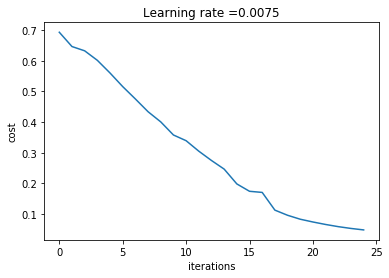

In [95]:
n_x = 64 * 64 * 3
n_h = 7
n_y = 1
layer_dims = (n_x, n_h, n_y)
params = two_layer_model(train_x, train_y, layer_dims = layer_dims, num_iterations = 2500, print_cost = True,
                         isPlot = True)

In [97]:
#预测
def predict(X,Y,params):
    """
    param:
    X:测试集
    Y:测试集标签
    params:训练好的参数
    
    return:
    pred:预测标签
    """
    m = X.shape[1]
    n = len(params) // 2
    pred = np.zeros((1, m))
    
    #前向传播
    probas, caches = multi_forward(X, params)
    
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            pred[0, i] = 1
        else:
            pred[0, i] = 0
            
    print('Accuracy:' + str(float(np.sum((pred == Y) / m))))
    
    return pred

In [99]:
print("双层网络下训练集：")
pred_train = predict(train_x,train_y, params)
print("双层网络下测试集：")
pred_test = predict(test_x, test_y, params)

双层网络下训练集：
Accuracy:0.9999999999999998
双层网络下测试集：
Accuracy:0.72


对比上一次的logistic regression的0.70的accuracy，准确率提升了2%
现在开始搭建多层网络

In [106]:
def L_layer_model(X, Y, layer_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False, isPlot = True):
    '''
    实现一个L层神经网络，前L-1层为relu激活，第L层为sigmoid激活
    
    param:
    X:输入数据 维度(n_x, m)
    Y:真实标签 维度(1, m)
    layer_dims:层数向量 维度(n_x, n_h, ..., n_h, n_y)
    learning_rate:学习率α
    num_iterations:迭代次数
    print_cost:是否打印成本每100次
    isPlot:是否绘制误差图
    
    return:
    params:包含W和b的字典
    '''
    np.random.seed(1)
    costs = []
    params = init_deep_params(layer_dims)
    
    for i in range(0, num_iterations):
        A_L, caches = multi_forward(X, params)
        cost = compute_cost(A_L, Y)
        grads = multi_backward(A_L, Y, caches)
        params = update_params(params, grads, learning_rate)
        
        if i % 100 == 0:
            costs.append(cost)
            
            if print_cost:
                print('第', i, '次迭代，成本为：', np.squeeze(cost))
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.xlabel('iterations')
        plt.ylabel('cost')
        plt.title('learning rate =' + str(learning_rate))
        plt.show()
    
    
    return params

第 0 次迭代，成本为： 0.7717493284237686
第 100 次迭代，成本为： 0.6720534400822913
第 200 次迭代，成本为： 0.6482632048575212
第 300 次迭代，成本为： 0.6115068816101354
第 400 次迭代，成本为： 0.5670473268366111
第 500 次迭代，成本为： 0.5401376634547801
第 600 次迭代，成本为： 0.5279299569455267
第 700 次迭代，成本为： 0.46547737717668514
第 800 次迭代，成本为： 0.369125852495928
第 900 次迭代，成本为： 0.3917469743480535
第 1000 次迭代，成本为： 0.3151869888600617
第 1100 次迭代，成本为： 0.2726998441789384
第 1200 次迭代，成本为： 0.23741853400268134
第 1300 次迭代，成本为： 0.19960120532208647
第 1400 次迭代，成本为： 0.18926300388463305
第 1500 次迭代，成本为： 0.1611885466582775
第 1600 次迭代，成本为： 0.14821389662363316
第 1700 次迭代，成本为： 0.13777487812972944
第 1800 次迭代，成本为： 0.1297401754919012
第 1900 次迭代，成本为： 0.12122535068005211
第 2000 次迭代，成本为： 0.1138206066863371
第 2100 次迭代，成本为： 0.10783928526254133
第 2200 次迭代，成本为： 0.10285466069352679
第 2300 次迭代，成本为： 0.10089745445261786
第 2400 次迭代，成本为： 0.09287821526472397


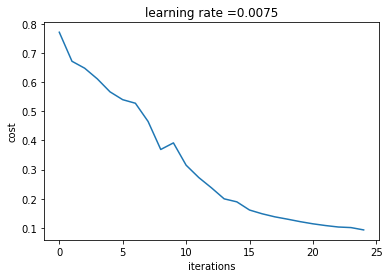

In [107]:
train_data, train_lable, test_data, test_label, classes = lr_utils.load_dataset()

train_x = train_data.reshape(train_data.shape[0], -1).T
test_x = test_data.reshape(test_data.shape[0], -1).T

train_x = train_x / 255
train_y = train_lable

test_x = test_x / 255
test_y = test_label
layer_dims = [12288, 20, 7, 5, 1]
params = L_layer_model(train_x, train_y, layer_dims, num_iterations = 2500, print_cost = True, isPlot = True)

In [108]:
print("五层网络下训练集：")
pred_train = predict(train_x,train_y, params)
print("五层网络下测试集：")
pred_test = predict(test_x, test_y, params)

五层网络下训练集：
Accuracy:0.9856459330143539
五层网络下测试集：
Accuracy:0.8


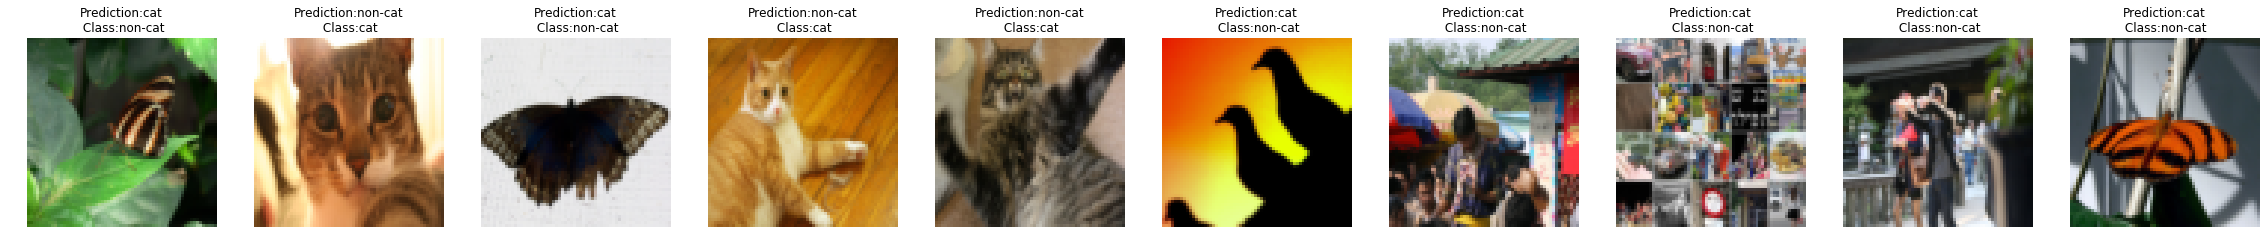

In [113]:
def print_mislabeled_images(classes, X, Y ,pred):
    a = pred + Y
    mislabeled_indices = np.asarray(np.where(a == 1))#1+0/0+1都是错 0+0/1+1是对的
    plt.rcParams['figure.figsize'] = (40, 40)
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:, index].reshape(64,64,3), interpolation = 'nearest')
        plt.axis('off')
        plt.title('Prediction:' + classes[int(pred[0, index])].decode('utf-8') + '\n Class:'
                 + classes[Y[0, index]].decode('utf-8'))
print_mislabeled_images(classes, test_x, test_y, pred_test)